In [4]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [5]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
import netCDF4 as nc

#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.35_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.2_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.15_N=100000.nc'

#dataset = 'viscek/dt=0.010_rho=1.000_v=0.500_a=4.000_eta=0.100_N=100000.nc'
dataset = 'viscek/dt=0.010_rho=1.000_v=0.500_a=4.000_eta=0.560_N=100000.nc'
# (don't interpolate)

ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["time"])
n_particles = len(ds.dimensions["director"])
deltat = 1
# deltat = 0.01
v = 0.5
positions = np.array(ds.variables["position"]).T.astype('float64')
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"]).astype('float64')
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): Nv(100000), dof(200000), boxdim(4), unit(1), time(1000), position(200000), director(100000)
    variables(dimensions): float32 time(time), float32 position(time, position), float32 director(time, director)
    groups: 
(1000, 100000)
(100000, 2, 1000)
(100000, 2, 1000)
[ 316.2277523  316.2277523 1000.       ]


0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


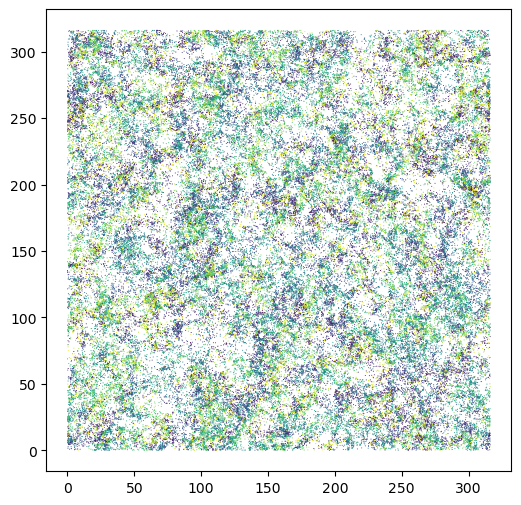

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viscek/eta0.56_t0.01.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [ ]:
#%%prun # profiling

from interp import *
from utils import roll, unroll

### computational effort can be cut down by only interpolating at domain locations, 
### but on the other hand the current way allows interpolation to be one and done
interp_factor = 10 #10x interpolation of data on intermediate times
old_pos = positions
old_vs = vs
positions, psplines = interp(unroll(positions, world_size), interp_factor, k=3)
print(positions.shape)
positions = roll(positions, world_size)
print(positions.shape)
vs, vsplines = interp(vs, interp_factor, k=3)
# overwrite vs using derivative of psplines (optional, not sure this is at all a good idea)
eval_pts = np.linspace(0, 1, num=positions.shape[-1])
derivative_vsplines = [spline.derivative() for spline in psplines]
derivative_vs_list = [vspline(eval_pts) for vspline in derivative_vsplines]
vs = np.transpose(np.dstack(derivative_vs_list))/(world_size[-1]-1) # normalization of e.g. [0, 49] to [0, 1]

deltat /= interp_factor
world_size[-1] = (world_size[-1]-1)*interp_factor+1

interesting = None # particle that wraps around
for i in range(positions.shape[0]):
    if np.max(np.abs(positions[i, :, 1:]-positions[i, :, :-1]))>100:
        interesting = i
plot_interp(old_pos[interesting, :, :], positions[interesting, :, :])
plot_interp(old_vs[interesting, :, :21], vs[interesting, :, :201])
print(positions[0, 0, 0:100:10], old_pos[0, 0, :10])
save('Q_XY_0.35_interp.npy', positions, vs, psplines, vsplines)

In [5]:
%%prun # profiling

#positions, vs = load('Q_XY_0.35_interp.npy', 2)

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
kernel_sigma = 2
cg_res = 1
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 80
dom_time = 50 #previously 20 (without interpolation)
srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*8) #ndomains = 30
srd.make_weights(m=8, qmax=1)
corr_L = 5
srd.set_LT_scale(L=corr_L, T=corr_L/v) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

#save('Q_XY_0.35.npy', srd.dxs, srd.libs)
save('Q_XY_t0.01_eta0.56.npy', srd.dxs, srd.libs)

         15925489 function calls (15128546 primitive calls) in 1204.736 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      150  656.148    4.374  656.150    4.374 coarse_grain_utils.py:96(coarse_grain_time_slices)
    39600  170.919    0.004  171.055    0.004 diff.py:478(_apply_to_array)
      888  105.083    0.118 1115.859    1.257 process_library_terms.py:373(make_tw_arr)
    39960   74.465    0.002   78.303    0.002 function_base.py:4129(trapz)
822914/396359   58.574    0.000  152.450    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    27360   24.792    0.001 1008.052    0.037 process_library_terms.py:184(eval_term)
    27480   24.511    0.001   71.782    0.003 process_library_terms.py:74(get_weight_array)
      150   21.241    0.142  685.580    4.571 process_library_terms.py:223(eval_cgp)
    13200   10.750    0.001  200.037    0.015 diff.py:277(diff)
   122340    6.707    0.000    6.

In [6]:
#_, libs = load('Q_XY_0.35.npy', 2)
_, libs = load('Q_XY_t0.01_eta0.56.npy', 2)
libs = libs.item()

In [7]:
from identify_models import *
opts = dict()
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
opts['method'] = "stepwise"
#opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2

[0.01 s]
Identified model: -0.25000000000000006 * rho + 1.0 * rho[v_j * v_j] = 0 (order 3, residual 1.63e-16)
[0.03 s]
Identified model: 0.9964561028334695 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 1.35e-03)
[0.07 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + -0.24999999999999992 * rho[v_i] = 0 (order 4, residual 8.08e-17)
[0.48 s]
Identified model: -0.24999999999999992 * rho * rho[v_i] + 1.0 * rho[v_i] * rho[v_j * v_j] = 0 (order 5, residual 9.98e-17)
[0.91 s]
Identified model: 0.9951298277479292 * dj rho * rho[v_i * v_j] + -0.25478758922293926 * rho * di rho + 1.0 * rho * dj rho[v_i * v_j] + -0.5186559917763932 * rho[v_i] * dj rho[v_j] + 0.5872701781968228 * rho[v_j] * di rho[v_j] + -0.5115054660945086 * rho[v_j] * dj rho[v_i] = 0 (order 5, residual 3.27e-03)
[1.31 s]
Identified model: -0.14464805156266197 * rho * rho[v_i] + 1.0 * rho[v_j] * rho[v_i * v_j] = 0 (order 5, residual 9.15e-03)


In [9]:
opts1['inhomog'] = True
opts1['method'] = 'stepwise'
opts1['subinds'] = range(len(libs[1].terms)) # if interleave_identify has been run, the subinds need to be cleared
opts1['verbose'] = True
# remove rho * burger's equation
#if 21 in opts1['subinds']:
#    opts1['subinds'].remove(21)
#    opts1['subinds'].remove(33)
subterms = [libs[1].terms[i] for i in opts1['subinds']]
col_number = find_term(subterms, 'dt rho[v_i]')
opts1['inhomog_col'] = col_number
opts1['n_terms'] = 3 # keep exactly this many terms
Xi, lambd, best_term, lambda1 = sparse_reg(libs[1].Q, **opts1)
zipped = [(subterms[i], c) for i, c in enumerate(Xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])
print(eqn, "; residual:", lambd)

Thetanm: 31831.219629863535
lambda: 2.0322633972291312e-16
nrm[0]: 0.16534420025937419
nrm[1]: 0.08644803473638686
nrm[2]: 0.056970680002860014
nrm[3]: 0.0511406401144628
nrm[4]: 0.042225446706411235
nrm[5]: 0.04644415613981638
nrm[6]: 0.19336973530280335
nrm[7]: 0.28693869576701697
nrm[8]: 0.23006715215730705
nrm[9]: 0.19400734663669741
nrm[10]: 0.26963249810706214
nrm[11]: 0.08087091814958478
nrm[12]: 0.15863648593229426
nrm[13]: 0.1665791269242139
nrm[14]: 0.05992214191026049
nrm[15]: 0.07217376291313718
nrm[16]: 0.232869987112329
nrm[17]: 0.4755842632071285
nrm[18]: 0.3215129870192673
nrm[19]: 0.3244979522495616
nrm[20]: 0.5500682685583412
nrm[21]: 0.23749891604388032
nrm[22]: 0.41810556102735313
nrm[23]: 0.33074479116060407
nrm[24]: 0.17632364787698607
nrm[25]: 0.11396078985694724
nrm[26]: 0.06024041820018514
nrm[27]: 0.14441795354971407
nrm[28]: 0.08211150475072801
nrm[29]: 0.10747602861385612
nrm[30]: 0.38671967671588975
nrm[31]: 0.19739793319578083
nrm[32]: 0.3867856220915186
n

In [19]:
res = libs[1].Q[:, opts1['subinds']] @ Xi
print(np.linalg.norm(res)/opts['anchor_norm'])
print(opts['anchor_norm'])

8.92658101098512e-05
31831.219629863535


In [ ]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [9]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size, term.complexity)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size, term.complexity)

0 1 1 0
1 rho 1.0000000867825747 1
2 dj^2 rho 0.021148319531244204 3
3 dj^2 dk^2 rho 0.0008459327812497682 5
4 dt rho 0.05287079882811051 2
5 dt dj^2 rho 0.0021148319531244203 4
6 dt^2 rho 0.005287079882811051 3
7 dt^2 dj^2 rho 0.00021148319531244205 5
8 dt^3 rho 0.0005287079882811051 4
9 dt^4 rho 5.287079882811051e-05 5
10 rho * rho 1.000000173565157 2
11 rho * dj^2 rho 0.021148321366549823 4
12 rho * dt rho 0.052870803416374554 3
13 rho * dt dj^2 rho 0.002114832136654982 5
14 rho * dt^2 rho 0.005287080341637456 4
15 rho * dt^3 rho 0.0005287080341637455 5
16 dj rho[v_j] 0.03738211322141162 3
17 dj^2 dk rho[v_k] 0.0014952845288564649 5
18 dt dj rho[v_j] 0.003738211322141162 4
19 dt^2 dj rho[v_j] 0.0003738211322141162 5
20 rho * dj rho[v_j] 0.03738211646552766 4
21 rho * dt dj rho[v_j] 0.0037382116465527657 5
22 rho[v_j * v_j] 0.12500001084782192 3
23 dj^2 rho[v_k * v_k] 0.0026430892285959785 5
24 dj dk rho[v_j * v_k] 0.0026430892285959785 5
25 dt rho[v_j * v_j] 0.006607723071489946 4
2

In [10]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho', 'dj rho[v_j]', 'dt^2 rho', 'dj^2 rho']

#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['1']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 4] 1.0 * dt rho. (Char. size: 0.05287079882811051)
[Term 16] 0.9964561028334695 * dj rho[v_j]. (Char. size: 0.03738211322141162)
Model residual: 0.014587787476303758


In [22]:
print(libs[0].Q[:10, 4], libs[0].Q[:10, 35])

IndexError: index 35 is out of bounds for axis 1 with size 33

0.07472391774531459 * di dj^2 rho + 0.0022590002778361184 * di rho + 1.0 * dt dj^2 rho[v_i] + 0.027115149548756615 * dt rho[v_i] + 0.3214469580646918 * dt^3 rho[v_i] + 0.009020284842689477 * rho * dj^2 rho[v_i] + 0.0003666771865221031 * rho * rho[v_i] = 0
frame=0
frame=0
frame=0
frame=10
frame=20
frame=30
frame=40


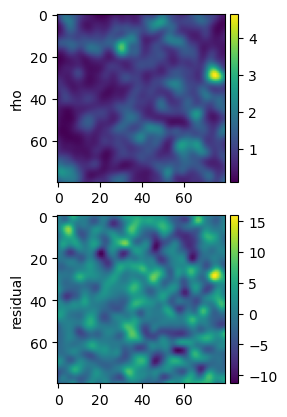

In [20]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test.mp3'

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

def make_all_but_first(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs[1:])[..., 0]

domain = srd.domains[0]
kc = 0 # can select x, y components

print(eqn)

#term1 = srd.libs[1].terms[find_term(libs[1].terms, 'dt rho[v_i]')]
#tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)[..., 0]
term1 = srd.libs[0].terms[find_term(libs[0].terms, 'rho')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], None, by_parts=False)[..., 0]
fig, (ax1, ax2) = plt.subplots(2, 1)
im1 = ax1.imshow(tw_arr[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

tw_arr2 = make_residual_arr(eqn, domain, kc) # or 
im2 = ax2.imshow(tw_arr2[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel("residual")

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    im1.set_array(tw_arr[:, :, i])
    im2.set_array(tw_arr2[:, :, i])
    vmax1 = np.max(tw_arr[:, :, i])
    vmin1 = np.min(tw_arr[:, :, i])
    vmax2 = np.max(tw_arr2[:, :, i])
    vmin2 = np.min(tw_arr2[:, :, i])
    im1.set_clim(vmin1, vmax1)
    im2.set_clim(vmin2, vmax2)

    return im1, im2

anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=100, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
#anim.save(vid_file, writer=FFwriter, dpi=100)
HTML(anim.to_html5_video())

#plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tw_arr[0, 0, :])
ax.plot(tw_arr[1, 0, :])
ax.plot(tw_arr[2, 0, :])

In [12]:
constraint_terms = ['rho', 'rho[v_j * v_j]']
col_numbers = [find_term(libs[0].terms, name) for name in constraint_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 1] -0.25000000000000006 * rho. (Char. size: 1.0000000867825747)
[Term 22] 1.0 * rho[v_j * v_j]. (Char. size: 0.12500001084782192)
Model residual: 1.904534383185466e-16


In [13]:
wave_terms = ['dt^2 rho', 'dj^2 rho']
col_numbers = [find_term(libs[0].terms, name) for name in wave_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 2] -0.11181842783089462 * dj^2 rho. (Char. size: 0.021148319531244204)
[Term 6] 1.0 * dt^2 rho. (Char. size: 0.005287079882811051)
Model residual: 0.6290349008238504


In [14]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 13] 0.7855595556050295 * dt rho[v_i]. (Char. size: 0.01869105661070581)
[Term 24] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.013215446142979892)
Model residual: 0.9382286489245848


In [15]:
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho', 'dj^2 rho[v_i]']
#euler_terms = ['dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in euler_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] -0.1288006358346379 * di rho. (Char. size: 0.10574159765622101)
[Term 13] 0.04932774267391998 * dt rho[v_i]. (Char. size: 0.01869105661070581)
[Term 24] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.013215446142979892)
Model residual: 0.156262168127653


In [20]:
toner_tu_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho[v_i] * dj rho[v_j]', 'rho[v_i]',
                'di rho', 'dj^2 rho[v_i]', 'di dj rho[v_j]']#, 'dj dk rho[v_i * v_j * v_k]', 
                #'rho * di rho', 'rho * rho * di rho']
# third term is a bit sketchy
col_numbers = [find_term(libs[1].terms, name) for name in toner_tu_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. \n(Char. size: {libs[1].col_weights[i]}, term contribution: {abs(np.linalg.norm(libs[1].Q[:, i])*Xi[i])})")
print("Model residual:", lambd)

[Term 0] -0.1267024724848922 * di rho. 
(Char. size: 0.10574159765622101, term contribution: 70.51365115380979)
[Term 10] 0.000858432714885881 * rho[v_i]. 
(Char. size: 0.3535534212755474, term contribution: 2.6048745881574287)
[Term 11] -0.1497542694278159 * di dj rho[v_j]. 
(Char. size: 0.0074764226442823245, term contribution: 2.8821641371313946)
[Term 12] 0.16442179825939363 * dj^2 rho[v_i]. 
(Char. size: 0.0074764226442823245, term contribution: 6.207398086536626)
[Term 13] 0.03450044902562242 * dt rho[v_i]. 
(Char. size: 0.01869105661070581, term contribution: 3.419262639819119)
[Term 24] 1.0 * dj rho[v_i * v_j]. 
(Char. size: 0.013215446142979892, term contribution: 74.17297022401283)
[Term 27] -0.02918467794844331 * rho[v_i] * dj rho[v_j]. 
(Char. size: 0.013216574023939956, term contribution: 1.773161380310089)
Model residual: 0.14270361965579725


In [ ]:
inhomog_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#inhomog_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho * dt rho[v_i]', 'rho * dj rho[v_i * v_j]']
#inhomog_terms = ['dt rho[v_i]', 'dt^2 di rho', 'rho * di rho', 'rho * dt di rho', 'rho * dt^2 di rho',
#                 'rho * dt^2 rho[v_i]']
#inhomog_terms = ['di rho', 'dt dj^2 rho[v_i]', 'dt rho[v_i]', 'dt^3 rho[v_i]']
#inhomog_terms = ['dt dj^2 rho[v_i]', 'dt rho[v_i]']
col_numbers = [find_term(libs[1].terms, name) for name in inhomog_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. \n(Char. size: {libs[1].col_weights[i]}, term contribution: {abs(np.linalg.norm(libs[1].Q[:, i])*Xi[i])})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined

In [ ]:
0.03 (0.99998), 0.018, 0.12, 0.08